In [4]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

from datetime import datetime
import time
import csv
sns.set_style("darkgrid")
results_2019 = pd.read_csv('./Runners_all_results_2019.csv', header = 0, encoding='latin-1', error_bad_lines=False)
results_2019['OfficialTime'] = results_2019['OfficialTime'].apply(lambda x: datetime.combine(datetime.min, datetime.strptime(x, '%H:%M:%S').time()) - datetime.min)
results_2019['OfficialTime'] = results_2019['OfficialTime'].apply(lambda x: x.total_seconds()/3600)
results_2019.head(2)

b'Skipping line 26144: expected 20 fields, saw 21\n'


,BibNumber,FullName,SortName,AgeOnRaceDay,Gender,City,StateAbbrev,StateName,Zip,CountryOfResAbbrev,CountryOfResName,CountryOfCtzAbbrev,CountryOfCtzName,OfficialTime,RankOverall,RankOverGender,RankOverDivision,EventGroup,SubGroupLabel,SubGroup
0,2,Lawrence Cherono,"Cherono, Lawrence",30,M,Eldoret,NaN,NaN,NaN,KEN,Kenya,KEN,Kenya,2.132500,1,1,1,Runners,NaN,NaN
1,6,Lelisa Desisa,"Desisa, Lelisa",29,M,Ambo,NaN,NaN,NaN,ETH,Ethiopia,ETH,Ethiopia,2.133056,2,2,2,Runners,NaN,NaN


import city elevation data

In [5]:
cities_elevation = pd.read_csv('cities.csv', header = 0, sep=' *, *', quotechar = '"', error_bad_lines=False, warn_bad_lines=False)
cities_elevation['Elevation'] = cities_elevation['Elevation'].apply(pd.to_numeric, errors='coerce')
results_2019 = results_2019.merge(cities_elevation.set_index("City"), left_on='City', right_on="City", how='left')

/home/micha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
results_2019.Gender[results_2019.Gender == 'M'] = 2
results_2019.Gender[results_2019.Gender == 'F'] = 0
results_2019.head(2)
points = results_2019[['OfficialTime', 'Elevation']].dropna()
points = points.to_numpy()

/home/micha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/micha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Data standardisation with [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [7]:
##jeśli dane są w jakiś sposób skorelowane to znaczy, że występuje redundancja danych, te dane nic nowego nie wnoszą
##są niepotrzebne

## if necessary to scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_points = scaler.fit_transform(points)


## Find clusters using [kMeans()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [8]:
#klasa KMeans z sklearn, konstruktor przyjmuje liczbę klastrów i sposób inicjalizacji centroidów, random_state=1 za
#każdym razem te same punkty startowe
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, init='random', random_state=1)
kmeans.fit(scaled_points)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

In [9]:
#funkcja predict zwaraca etykiety klastru do jakiego został przypisany obiekt
clusters_id = kmeans.predict(scaled_points)

In [10]:
#pozycje centroidów
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)

Text(0, 0.5, 'City of residence elevation [m]')

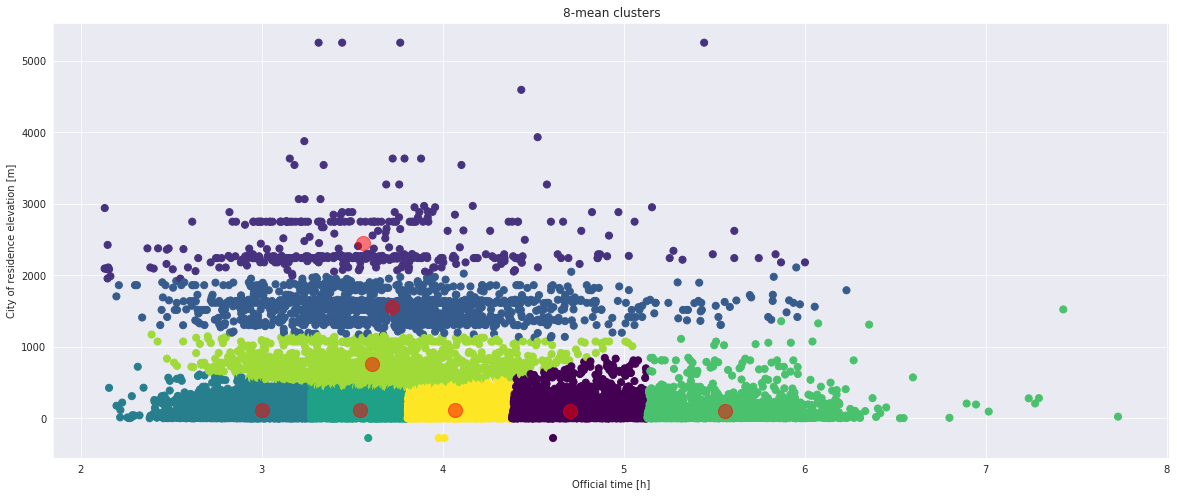

In [11]:
#każdy kolejny klaster dostaje inny kolor
plt.figure(figsize=(20,8))
plt.scatter(points[:, 0], points[:, 1], c=clusters_id, s=50, cmap='viridis')
#duże czerwone kropki to pozycje centroidów
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.title("8-mean clusters")
plt.xlabel("Official time [h]")
plt.ylabel("City of residence elevation [m]")

#klastrowanie w oparciu o oficjalny czas i wysokość miasta zamieszkania
#dane ustandaryzwoane
# trzy klastry horyzontalne w zależności od wysokości
# pięć klastrów w zależności od uzyskanego czasu


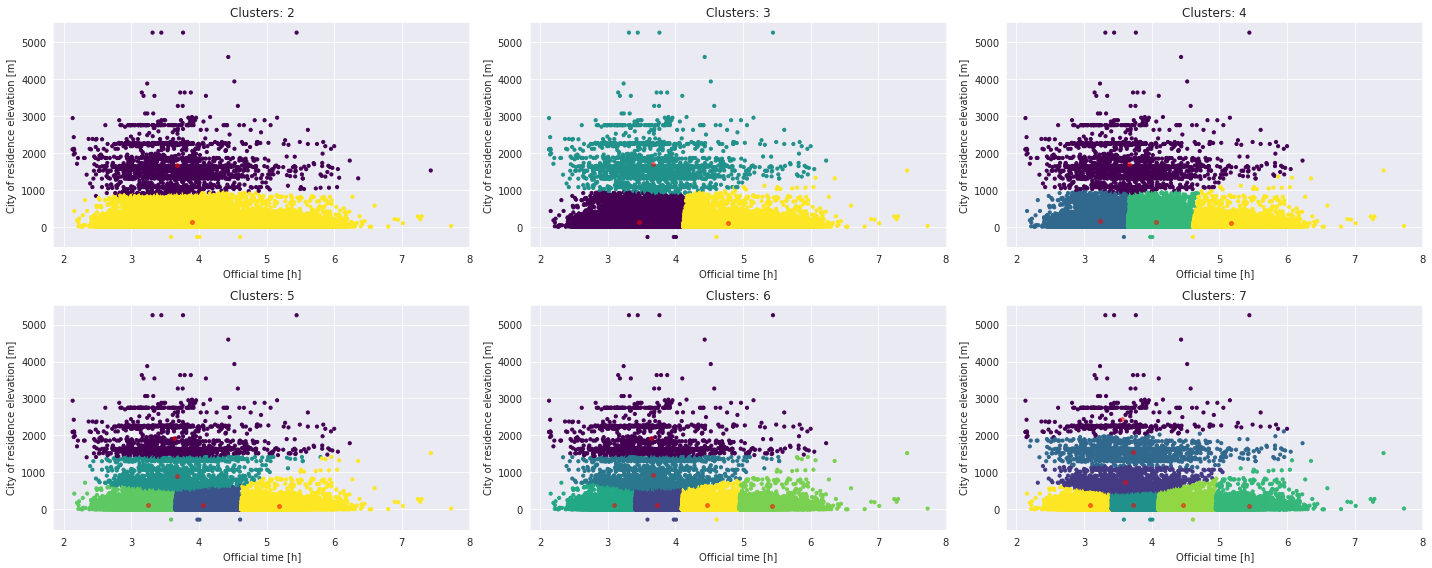

In [15]:
#jak będzie się zmieniać klasteryzacja gdy zadamy inną ilość klastrów
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
for k in [2,3,4,5,6,7]:
    kmeans_ = KMeans(n_clusters=k, init='random', random_state=1)
    kmeans_.fit(scaled_points)
    clusters_id_ = kmeans_.predict(scaled_points)
    plt.subplot("23"+str(k-1))
    plt.scatter(points[:, 0], points[:, 1], c=clusters_id_ , s=10, cmap='viridis')

    centroids_ = kmeans_.cluster_centers_
    centroids_ = scaler.inverse_transform(centroids_)

    plt.scatter(centroids_[:, 0], centroids_[:, 1], c='red', s=15, alpha=0.5)
    plt.title("Clusters: "+str(k))
    plt.xlabel("Official time [h]")
    plt.ylabel("City of residence elevation [m]")
plt.tight_layout()
#klastrowanie w oparciu o oficjalny czas i wysokość miasta zamieszkania
#dane ustandaryzowane